In [1]:
!pip install catboost optuna tsfresh

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor, Pool, cv
import optuna

from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.feature_selection import f_classif, SelectKBest

from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute

In [66]:
df = pd.read_csv("/content/final_data_agg.csv",sep = ";", index_col = 0)
df.head()

,time,day_of_week,month,salary_week,season,revenue,avg_temp,snow,rain
0,2022-09-01,3,9,0,3,96630.0,11.4,0,0
1,2022-09-02,4,9,0,3,108024.5,10.5,0,1
2,2022-09-03,5,9,0,3,122352.0,12.5,0,0
3,2022-09-04,6,9,0,3,119441.7,12.2,0,0
4,2022-09-05,0,9,0,3,87863.5,10.3,0,0


In [67]:
df["id"] = range(len(df))
extracted_features = extract_features(df, column_id='id', column_sort='time')

Feature Extraction: 100%|██████████| 3360/3360 [01:47<00:00, 31.39it/s]


In [68]:
impute(extracted_features)

/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['day_of_week__mean_abs_change' 'day_of_week__mean_change'
 'day_of_week__mean_second_derivative_central' ...
 'rain__permutation_entropy__dimension_7__tau_1'
 'rain__query_similarity_count__query_None__threshold_0.0'
 'rain__mean_n_absolute_max__number_of_maxima_7'] did not have any finite values. Filling with zeros.
  warnings.warn(


,day_of_week__variance_larger_than_standard_deviation,day_of_week__has_duplicate_max,day_of_week__has_duplicate_min,day_of_week__has_duplicate,day_of_week__sum_values,day_of_week__abs_energy,day_of_week__mean_abs_change,day_of_week__mean_change,day_of_week__mean_second_derivative_central,day_of_week__median,...,rain__fourier_entropy__bins_5,rain__fourier_entropy__bins_10,rain__fourier_entropy__bins_100,rain__permutation_entropy__dimension_3__tau_1,rain__permutation_entropy__dimension_4__tau_1,rain__permutation_entropy__dimension_5__tau_1,rain__permutation_entropy__dimension_6__tau_1,rain__permutation_entropy__dimension_7__tau_1,rain__query_similarity_count__query_None__threshold_0.0,rain__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,0.0,0.0,3.0,9.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,4.0,16.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,5.0,25.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,6.0,36.0,0.0,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,0.0,0.0,0.0,0.0,6.0,36.0,0.0,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
417,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
418,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
extracted_features["id"] = range(len(df))

In [70]:
#extracted_features.reset_index(inplace = True)
#extracted_features.rename({"index":"id"}, inplace = True)
df = pd.merge(df, extracted_features, on='id')
df.drop("id", axis = 1, inplace = True)
df.head()

,time,day_of_week,month,salary_week,season,revenue,avg_temp,snow,rain,day_of_week__variance_larger_than_standard_deviation,...,rain__fourier_entropy__bins_5,rain__fourier_entropy__bins_10,rain__fourier_entropy__bins_100,rain__permutation_entropy__dimension_3__tau_1,rain__permutation_entropy__dimension_4__tau_1,rain__permutation_entropy__dimension_5__tau_1,rain__permutation_entropy__dimension_6__tau_1,rain__permutation_entropy__dimension_7__tau_1,rain__query_similarity_count__query_None__threshold_0.0,rain__mean_n_absolute_max__number_of_maxima_7
0,2022-09-01,3,9,0,3,96630.0,11.4,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-09-02,4,9,0,3,108024.5,10.5,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-09-03,5,9,0,3,122352.0,12.5,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-09-04,6,9,0,3,119441.7,12.2,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-09-05,0,9,0,3,87863.5,10.3,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
def drop_uninformative(data, threshold = 0.99):

  for column in data.columns:
    max_freq = data[column].value_counts(normalize=True).max()
    if max_freq >= threshold:
      data.drop(column, axis=1, inplace=True)
      print(f"Колонка {column} удалена")


In [72]:
drop_uninformative(df)

Выходные данные были обрезаны до нескольких последних строк (5000).
Колонка month__fft_coefficient__attr_"real"__coeff_57 удалена
Колонка month__fft_coefficient__attr_"real"__coeff_58 удалена
Колонка month__fft_coefficient__attr_"real"__coeff_59 удалена
Колонка month__fft_coefficient__attr_"real"__coeff_60 удалена
Колонка month__fft_coefficient__attr_"real"__coeff_61 удалена
Колонка month__fft_coefficient__attr_"real"__coeff_62 удалена
Колонка month__fft_coefficient__attr_"real"__coeff_63 удалена
Колонка month__fft_coefficient__attr_"real"__coeff_64 удалена
Колонка month__fft_coefficient__attr_"real"__coeff_65 удалена
Колонка month__fft_coefficient__attr_"real"__coeff_66 удалена
Колонка month__fft_coefficient__attr_"real"__coeff_67 удалена
Колонка month__fft_coefficient__attr_"real"__coeff_68 удалена
Колонка month__fft_coefficient__attr_"real"__coeff_69 удалена
Колонка month__fft_coefficient__attr_"real"__coeff_70 удалена
Колонка month__fft_coefficient__attr_"real"__coeff_71 удалена
Ко

In [ ]:
df = df[["time", "day_of_week", "month","salary_week", "season", "avg_temp", "snow", "rain", "revenue"]]
df.head()

In [ ]:
df.rename(columns = {
    "Открыт_дата":"time",
    "День недели":"day_of_week",
    "Месяц": "month",
    "ЗП":"salary_week",
    "Время года":"season",
    "Сумма по чеку, руб.":"revenue",
    "Средняя Температура":"avg_temp",
    "Снег":"snow",
    "Дождь":"rain",
    "Год":"year",
    "Неделя":"week",
    "День":"day"
}, inplace = True)

In [73]:
for i in range(1, 8):
  df[i] = df["revenue"].shift(i)

df.head()

,time,day_of_week,month,salary_week,season,revenue,avg_temp,snow,rain,day_of_week__sum_values,...,rain__value_count__value_1,rain__range_count__max_1__min_-1,rain__count_below__t_0,1,2,3,4,5,6,7
0,2022-09-01,3,9,0,3,96630.0,11.4,0,0,3.0,...,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-09-02,4,9,0,3,108024.5,10.5,0,1,4.0,...,1.0,0.0,0.0,96630.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-09-03,5,9,0,3,122352.0,12.5,0,0,5.0,...,0.0,1.0,1.0,108024.5,96630.0,NaN,NaN,NaN,NaN,NaN
3,2022-09-04,6,9,0,3,119441.7,12.2,0,0,6.0,...,0.0,1.0,1.0,122352.0,108024.5,96630.0,NaN,NaN,NaN,NaN
4,2022-09-05,0,9,0,3,87863.5,10.3,0,0,0.0,...,0.0,1.0,1.0,119441.7,122352.0,108024.5,96630.0,NaN,NaN,NaN


In [74]:
df.shape

(420, 224)

In [75]:
df.dropna(inplace = True)
df.shape

(413, 224)

In [78]:
train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size:]

X_train_global, y_train_global = train.drop(["time", "revenue"], axis = 1), train["revenue"]
X_test_global, y_test_global = test.drop(["time", "revenue"], axis = 1), test["revenue"]

In [79]:
def objective(trial):
  params = {
        'iterations': trial.suggest_int('iterations', 200, 3000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1, 15),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'loss_function': 'RMSE',
        'verbose': False
    }

  tscv = TimeSeriesSplit(n_splits=5)
  scores = []

  for train_index, test_index in tscv.split(X_train_global):
      X_train, X_test = X_train_global.iloc[train_index], X_train_global.iloc[test_index]
      y_train, y_test = y_train_global.iloc[train_index], y_train_global.iloc[test_index]

      train_pool = Pool(data = X_train, label = y_train)

      model = CatBoostRegressor(**params)
      model.fit(train_pool, eval_set=(X_test, y_test), verbose = 0)

      predictions = model.predict(X_test)
      score = np.sqrt(mean_squared_error(y_test, predictions))
      scores.append(score)

  mean_cv_error = np.mean(scores)
  return mean_cv_error

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-02-03 09:27:05,645] A new study created in memory with name: no-name-728b404f-3730-42dd-b1fb-88a16a16ab29
<ipython-input-79-83f0450927b5>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
<ipython-input-79-83f0450927b5>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1, 15),
[W 2024-02-03 09:27:48,275] Trial 0 failed with parameters: {'iterations': 1645, 'depth': 6, 'learning_rate': 0.0334175658684628, 'l2_leaf_reg': 1.9271537317854381, 'border_count': 159} because of the following error: KeyboardInterrupt('').
Traceback (most recent call

KeyboardInterrupt: 

In [ ]:
print('Лучшие параметры:', study.best_params)
print(study.best_value)

In [ ]:
params = study.best_params
model = CatBoostRegressor(**params)
model.fit(X_train_global, y_train_global, verbose=0)
round((mean_absolute_percentage_error(y_test_global, model.predict(X_test_global))), 3)

In [ ]:
study.best_params

{'iterations': 2113,
 'depth': 4,
 'learning_rate': 0.25215064774169627,
 'l2_leaf_reg': 1.2332320485231583,
 'border_count': 105}

In [ ]:
def metric(y_pred, y_test):
  #print(f"======= Резултаты {model_name} =======")
  print()
  print("RMSE = ", round(np.sqrt(mean_squared_error(y_test, y_pred)), 3))
  print("MAE = ", round(mean_absolute_error(y_test, y_pred),3))
  print("MAPE = ", round(mean_absolute_percentage_error(y_test, y_pred),3))
  print()

In [ ]:
predictions = model.predict(X_test_global)
metric(predictions, y_test_global)


RMSE =  13700.403
MAE =  10231.9
MAPE =  0.115



In [ ]:
model.predict(X_test_global)

array([ 75968.9128262 ,  80181.84366622,  61879.73421439,  67504.03057297,
        71618.4228183 ,  70514.8810416 ,  77309.96040573,  81057.57901156,
        81520.5277907 ,  70374.03480734,  66915.82583423,  76928.35391804,
        77944.42482364,  78231.10280183,  85703.84977341,  93048.79853608,
        70167.8767563 ,  80376.82088894,  76046.27847402,  76998.9969727 ,
        84845.16493536, 100140.98096301,  97769.06430011,  75431.0047792 ,
        86775.64008492,  74152.40871477,  76837.85168017,  87265.76298202,
       102995.67461481,  98191.57954231,  87217.31473134,  84661.14003837,
        84500.35785831,  96524.1221568 , 101331.09068478, 105383.18598431,
       109792.5354574 ,  86248.94581758,  97711.07550033, 101930.81684044,
       104293.69045387, 113014.79727952, 106194.39882697, 112377.95900957,
        91192.92279104,  91004.74276093,  92203.13501188,  91647.04085989,
        99992.60378907, 111309.3610858 , 100246.84354495,  74848.93870739,
        83245.73504085,  

In [ ]:
prediction = pd.concat([train["revenue"], pd.Series(model.predict(X_test_global), index = list(range(337, 337 + len(model.predict(X_test_global)))))], axis = 0)

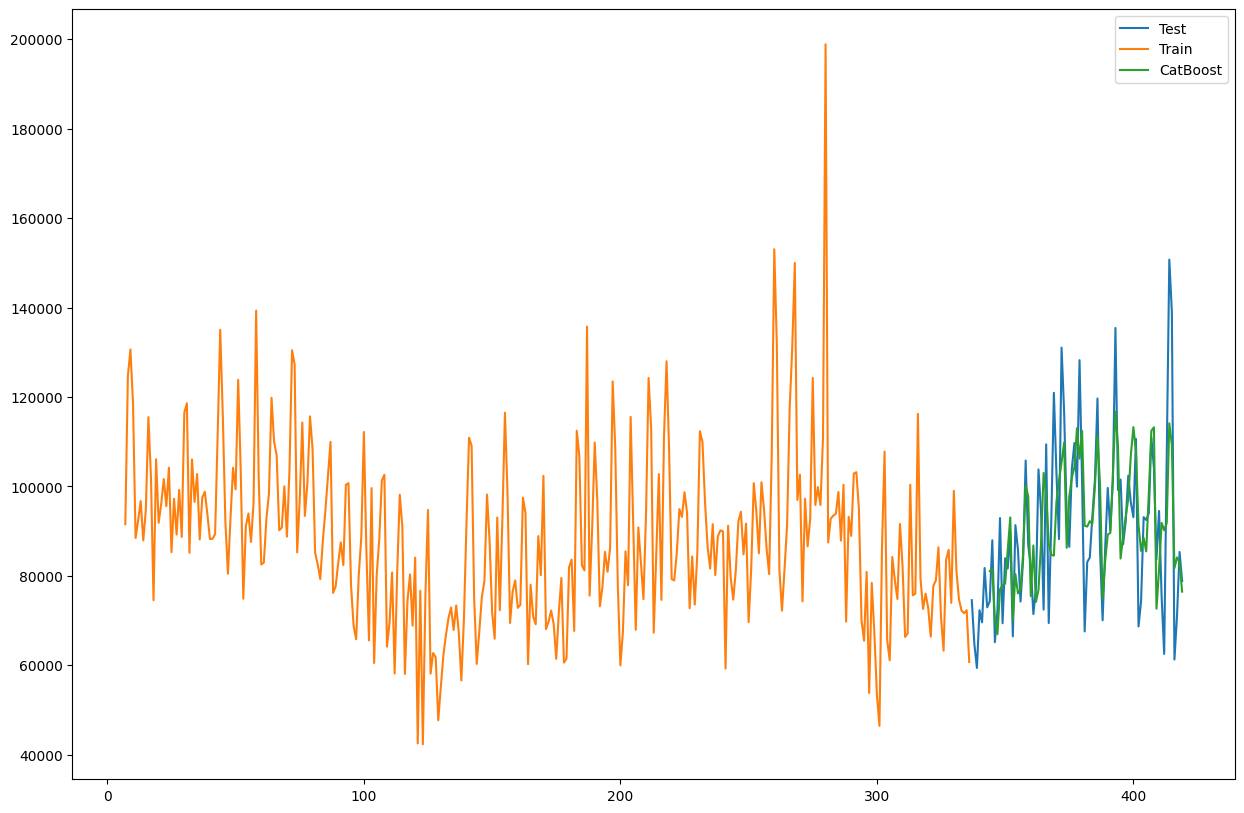

In [ ]:
#predict = pd.concat([train["revenue"], model.predict(X_test_global)], axis = 0)
plt.figure(figsize = (15, 10))
plt.plot(y_test_global, label = "Test")
plt.plot(train["revenue"], label = "Train")
plt.plot(prediction[337:], label = "CatBoost")
plt.legend()
plt.show()

In [ ]:
feature = pd.DataFrame()
feature["feature"] = X_train_global.columns
feature["importances"] = model.feature_importances_
feature.sort_values(by = "importances", ascending = False)

,feature,importances
0,day_of_week,19.087777
10,1,13.779595
16,7,11.510934
14,5,9.454009
12,3,8.404107
7,avg_temp,6.328739
15,6,5.835994
11,2,5.470288
13,4,5.195605
5,season,3.990912


In [ ]:
model.feature_importances_

array([19.08777724,  1.92898879,  0.31376341,  2.24727807,  0.5755546 ,
        3.99091179,  3.84677921,  6.32873937,  0.44344621,  1.58622912,
       13.77959537,  5.47028763,  8.40410743,  5.19560471,  9.45400902,
        5.83599448, 11.51093355])

In [ ]:
X_train_global.columns

Index(['day_of_week',       'month',        'year',        'week',
       'salary_week',      'season',         'day',    'avg_temp',
              'snow',        'rain',             1,             2,
                   3,             4,             5,             6,
                   7],
      dtype='object')